<a href="https://colab.research.google.com/github/AnabelleSouza/CRUD_PDO-CONTEINER/blob/main/Heart_Disease_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AULA 1 ATÉ 4

In [1]:
pip install ucimlrepo

In [2]:
import pandas as pd
import pymc as pm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import fetch_openml
from ucimlrepo import fetch_ucirepo
import arviz as az
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder as LB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler as SS
from sklearn.model_selection import train_test_split as tts
import pytensor.tensor as tt


from math import sqrt

In [3]:

# Fetch dataset
heart_disease = fetch_ucirepo(id=45)

# Data (as pandas dataframes)
X = heart_disease.data.features
y = heart_disease.data.targets

# Checar metadata
print(heart_disease.metadata)

# Ver informações sobre as variáveis
print(heart_disease.variables)

# Verificar a estrutura dos dados
print(X.head())
print(y.head())

# Padronizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M

In [4]:
print(X.head())  # Verificar as features
print(y.head())  # Verificar a variável alvo
# Convertendo y para uma Series, se for um DataFrame de uma coluna
y_series = y.squeeze()  # Isso converte DataFrame com uma coluna para Series
print(y_series.unique())  # Verificar os valores únicos



   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

    ca  thal  
0  0.0   6.0  
1  3.0   3.0  
2  2.0   7.0  
3  0.0   3.0  
4  0.0   3.0  
   num
0    0
1    2
2    1
3    0
4    0
[0 2 1 3 4]


In [11]:
# Transformar a variável alvo em binária (0 = sem doença, 1 = com doença)
y_binary = y_series.apply(lambda x: 1 if x > 0 else 0)

print(y_binary.unique())  # Verificar os valores únicos após a transformação


[0 1]


In [12]:


def analise_priori(trace, y):
    fig, axes = plt.subplots(3, 2, figsize=(10, 10), gridspec_kw={'hspace': 0.4, 'wspace': 0.3})

    # Histograma para os betas (priors)
    betas_values = trace.prior['betas'].values.flatten()  # Convertendo primeiro para Numpy array, depois achatando
    sns.histplot(betas_values, bins=20, kde=True, ax=axes[0][0])
    axes[0][0].set_xlabel("Betas")
    axes[0][0].set_ylabel("Contagem")

    # Histograma para as previsões da variável dependente (priors)
    y_obs_values = trace.prior_predictive['Y_obs'].values.flatten()  # Convertendo primeiro para Numpy array, depois achatando
    sns.histplot(y_obs_values, bins=20, kde=True, ax=axes[0][1])
    axes[0][1].set_xlabel("Y_obs (Previsões a Priori)")
    axes[0][1].set_ylabel("Contagem")

    # Previsões a priori
    prior_samples = trace.prior_predictive['Y_obs'].values  # Apenas convertendo para Numpy array
    prior_samples_reshaped = prior_samples.reshape(len(y), -1)

    # Cálculo da média e desvio padrão das previsões a priori
    mean_pred = np.mean(prior_samples_reshaped, axis=1)
    std_pred = np.std(prior_samples_reshaped, axis=1)

    # Plotar as previsões médias a priori
    sns.lineplot(x=range(len(y)), y=mean_pred, ax=axes[1][0])
    axes[1][0].fill_between(range(len(y)), mean_pred - std_pred, mean_pred + std_pred, alpha=0.2)

    axes[1][0].set_title("Previsões a Priori")
    axes[1][0].set_xlabel("Observado")
    axes[1][0].set_ylabel("Previsões")
    axes[1][0].legend(['Previsões Médias'])

    # Gráficos cumulativos da priori usando Arviz
    az.plot_ppc(trace, group='prior', kind='cumulative', ax=axes[2][0], observed=True)
    az.plot_ppc(trace, group='prior', ax=axes[2][1], observed=True)

    plt.tight_layout()
    return fig, axes


In [7]:
# # Verificar X_scaled
# print(f"Shape de X_scaled: {X_scaled.shape}")
# print(f"Valores nulos em X_scaled: {np.isnan(X_scaled).sum()}")
# print(f"Valores infinitos em X_scaled: {np.isinf(X_scaled).sum()}")

# # Verificar y
# print(f"Shape de y: {y.shape}")
# print(f"Valores nulos em y: {np.isnan(y).sum()}")
# print(f"Valores infinitos em y: {np.isinf(y).sum()}")


In [17]:


# Se X_scaled for um numpy array, converta para DataFrame para facilitar o tratamento de valores nulos
X_scaled_df = pd.DataFrame(X_scaled)

# Substituir os valores nulos pela média da coluna
X_scaled_df.fillna(X_scaled_df.mean(), inplace=True)

# Verificar se há valores nulos restantes
print(f"Valores nulos após o tratamento: {X_scaled_df.isnull().sum().sum()}")

# Converter de volta para numpy array, se necessário
X_scaled = X_scaled_df.values


Valores nulos após o tratamento: 0


In [19]:
print(f"Valores nulos em X_scaled após o tratamento: {np.isnan(X_scaled).sum()}")


Valores nulos em X_scaled após o tratamento: 0


RIDGE

In [20]:
# Certifique-se de que y tenha a forma correta
y = np.array(y_binary).reshape(-1) # Garante que y seja um vetor unidimensional (n_samples,)

# Definir as coordenadas do modelo
coords = {'features': np.arange(X_scaled.shape[1])}

# Criar o modelo Ridge Bayesiano
with pm.Model(coords=coords) as model_ridge:
    # Priori para o intercepto (alpha)
    alpha = pm.Normal('alpha', mu=0, sigma=10)

    # Priori para os coeficientes de regressão (betas)
    betas = pm.Normal('betas', mu=0, sigma=10, dims='features')

    # Priori para o desvio padrão do erro (epsilon)
    epsilon = pm.Gamma('epsilon', alpha=2, beta=1)  # Gamma prior para epsilon

    # Definir a equação do modelo linear
    mu = alpha + tt.dot(X_scaled, betas)  # Deve resultar em um vetor de tamanho (n_samples,)

    # Definir a verossimilhança (Normal)
    likelihood = pm.Normal('Y_obs', mu=mu, sigma=epsilon, observed=y)

    # Amostrar da distribuição a priori
    ridge_trace_prior = pm.sample_prior_predictive()

    # Amostrar da distribuição posterior
    trace_ridge = pm.sample(1000, tune=1000, target_accept=0.95)


Output()

Output()

In [22]:
with model_ridge:
  posterior_predictive = pm.sample_posterior_predictive(trace_ridge)

Output()

In [23]:
# Verificar as chaves do posterior preditivo
print(posterior_predictive.keys())



KeysView(Inference data with groups:
	> posterior_predictive
	> observed_data)


In [24]:
# Verificar as chaves do posterior_predictive
print(posterior_predictive['posterior_predictive'].keys())

# Verificar as chaves do observed_data
print(posterior_predictive['observed_data'].keys())


KeysView(<xarray.Dataset> Size: 5MB
Dimensions:      (chain: 2, draw: 1000, Y_obs_dim_2: 303)
Coordinates:
  * chain        (chain) int64 16B 0 1
  * draw         (draw) int64 8kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * Y_obs_dim_2  (Y_obs_dim_2) int64 2kB 0 1 2 3 4 5 ... 297 298 299 300 301 302
Data variables:
    Y_obs        (chain, draw, Y_obs_dim_2) float64 5MB 0.3173 1.236 ... 0.5394
Attributes:
    created_at:                 2024-09-24T15:48:52.848276+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.16.2)
KeysView(<xarray.Dataset> Size: 5kB
Dimensions:      (Y_obs_dim_0: 303)
Coordinates:
  * Y_obs_dim_0  (Y_obs_dim_0) int64 2kB 0 1 2 3 4 5 ... 297 298 299 300 301 302
Data variables:
    Y_obs        (Y_obs_dim_0) float64 2kB 0.0 1.0 1.0 0.0 ... 1.0 1.0 1.0 0.0
Attributes:
    created_at:                 2024-09-24T15:48:52.852905+00:00
    arviz_version:              0.19.0
    inference_library:     

In [25]:
# Acessar dados preditivos de Y_obs
y_obs_pred = posterior_predictive['posterior_predictive']['Y_obs']
print(y_obs_pred)

# Cálculo da média ou outras estatísticas
y_obs_mean = y_obs_pred.mean(axis=0)
print(y_obs_mean)


<xarray.DataArray 'Y_obs' (chain: 2, draw: 1000, Y_obs_dim_2: 303)> Size: 5MB
array([[[ 0.31734251,  1.23551444,  1.33467955, ...,  0.90180359,
         -0.13560489,  0.13137035],
        [ 0.10432712,  1.15778541,  1.15126688, ...,  1.32270652,
          0.11465688,  0.7246668 ],
        [ 0.5409331 ,  1.47189342,  1.34387796, ...,  0.17251871,
         -0.21852476,  0.12138639],
        ...,
        [ 0.8471033 ,  1.30803767,  1.03429066, ...,  1.10041424,
         -0.08200586,  0.42562686],
        [ 0.53454731,  1.7118202 ,  1.4324044 , ...,  0.84157491,
         -0.28806896,  0.31073989],
        [ 0.19016355,  1.37162609,  0.8532001 , ...,  1.07540987,
          0.14329542,  0.09091499]],

       [[-0.02190482,  1.531323  ,  0.99600029, ...,  0.93829023,
          0.06911873,  0.7032399 ],
        [ 0.87302662,  1.35277139,  1.30222242, ...,  0.51139469,
          0.20628894,  0.38641472],
        [ 0.41443018,  0.91981347,  0.96155957, ...,  1.1833725 ,
         -0.10391721,  0.

In [26]:
# Certifique-se de que y está disponível
print(y)


[0 1 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 1 0 1 1 0 0 0 1
 1 1 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 1 0 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1
 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 1 1 1 1
 1 0 1 1 0 0 0 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 1 0 1 1 0
 0 0 0 0 0 1 1 1 1 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1
 0 0 1 1 1 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 1 1 1 0 1 0 1 0 1 1 0 0 0 0 0 0 0
 0 1 1 0 0 0 1 1 0 1 1 0 0 1 1 1 0 0 0 0 0 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0
 1 0 1 0 0 1 1 1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 1 1 1 0 0 0 1 0 1 1 1 0
 1 1 1 1 1 1 0]


<ipython-input-12-720b9792f2ee>:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


(<Figure size 1000x1000 with 6 Axes>,
 array([[<Axes: xlabel='Betas', ylabel='Contagem'>,
         <Axes: xlabel='Y_obs (Previsões a Priori)', ylabel='Contagem'>],
        [<Axes: title={'center': 'Previsões a Priori'}, xlabel='Observado', ylabel='Previsões'>,
         <Axes: >],
        [<Axes: xlabel='Y_obs'>, <Axes: xlabel='Y_obs'>]], dtype=object))

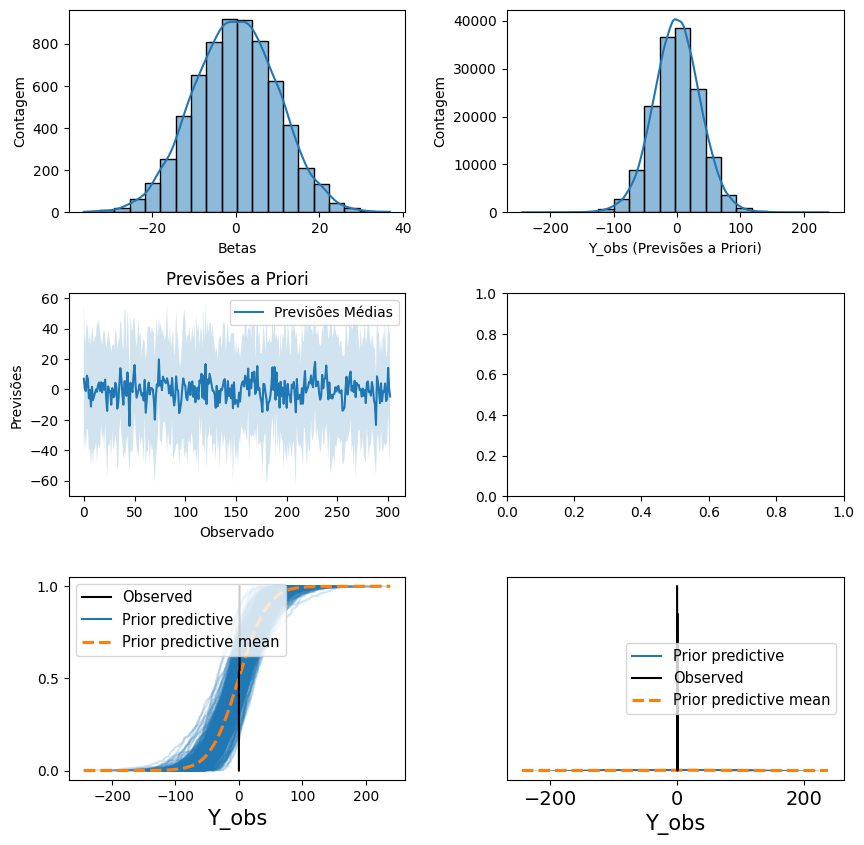

In [27]:

analise_priori(ridge_trace_prior, y)


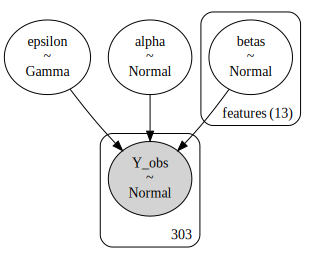

In [28]:

pm.model_to_graphviz(model_ridge)

In [29]:


pm.summary(trace_ridge)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.459,0.020,0.420,0.495,0.000,0.000,3794.0,1556.0,1.00
betas[0],-0.011,0.025,-0.056,0.036,0.001,0.001,2424.0,1526.0,1.00
betas[1],0.069,0.023,0.028,0.114,0.000,0.000,2934.0,1578.0,1.00
betas[2],0.083,0.024,0.038,0.125,0.000,0.000,3277.0,1543.0,1.00
betas[3],0.036,0.022,-0.006,0.076,0.000,0.000,3179.0,1637.0,1.00
betas[4],0.021,0.022,-0.018,0.062,0.000,0.000,2185.0,1490.0,1.00
betas[5],-0.026,0.021,-0.064,0.013,0.000,0.000,3459.0,1559.0,1.00
betas[6],0.032,0.021,-0.004,0.075,0.000,0.000,2731.0,1217.0,1.00
betas[7],-0.056,0.026,-0.104,-0.007,0.001,0.000,2668.0,1630.0,1.00
betas[8],0.069,0.024,0.019,0.111,0.000,0.000,3251.0,1300.0,1.01


In [30]:
def analise_posteriori(trace):
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  az.plot_ppc(trace, group='posterior', kind='cumulative', ax=axes[0]);
  az.plot_ppc(trace, group='posterior',ax=axes[1]);

  return fig, axes

Output()

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: xlabel='Y_obs'>, <Axes: xlabel='Y_obs'>], dtype=object))

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


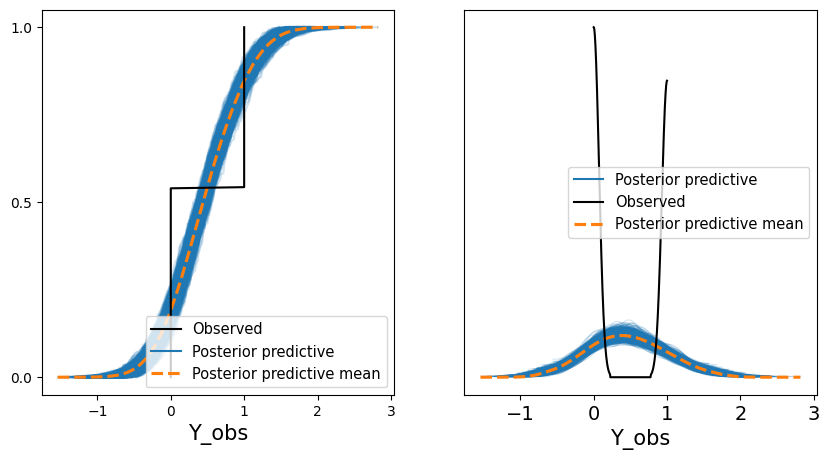

In [31]:

with model_ridge:
  trace_pos_ridge = pm.sample_posterior_predictive(trace_ridge)

analise_posteriori(trace_pos_ridge)


LASSO

In [32]:

# Definir as coordenadas do modelo
coords = {'features': np.arange(X_scaled.shape[1])}

# Criar o modelo Lasso Bayesiano
with pm.Model(coords=coords) as model_lasso:
    # Priori para o intercepto (alpha)
    alpha = pm.Normal('alpha', mu=0, sigma=10)

    # Priori para os coeficientes de regressão (betas) com priori Laplace
    betas = pm.Laplace('betas', mu=0, b=1/sqrt(2), dims='features')  # b é o parâmetro de escala da Laplace

    # Priori para o desvio padrão do erro (epsilon)
    epsilon = pm.Gamma('epsilon', alpha=2, beta=1)

    # Definir a equação do modelo linear
    mu = alpha + tt.dot(X_scaled, betas)

    # Definir a verossimilhança (Normal)
    likelihood = pm.Normal('Y_obs', mu=mu, sigma=epsilon, observed=y)

    # Amostrar da distribuição a priori
    lasso_trace_prior = pm.sample_prior_predictive()

    # Amostrar da distribuição posterior
    trace_lasso = pm.sample(1000, tune=1000, target_accept=0.95)


Output()

Output()

<ipython-input-12-720b9792f2ee>:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


(<Figure size 1000x1000 with 6 Axes>,
 array([[<Axes: xlabel='Betas', ylabel='Contagem'>,
         <Axes: xlabel='Y_obs (Previsões a Priori)', ylabel='Contagem'>],
        [<Axes: title={'center': 'Previsões a Priori'}, xlabel='Observado', ylabel='Previsões'>,
         <Axes: >],
        [<Axes: xlabel='Y_obs'>, <Axes: xlabel='Y_obs'>]], dtype=object))

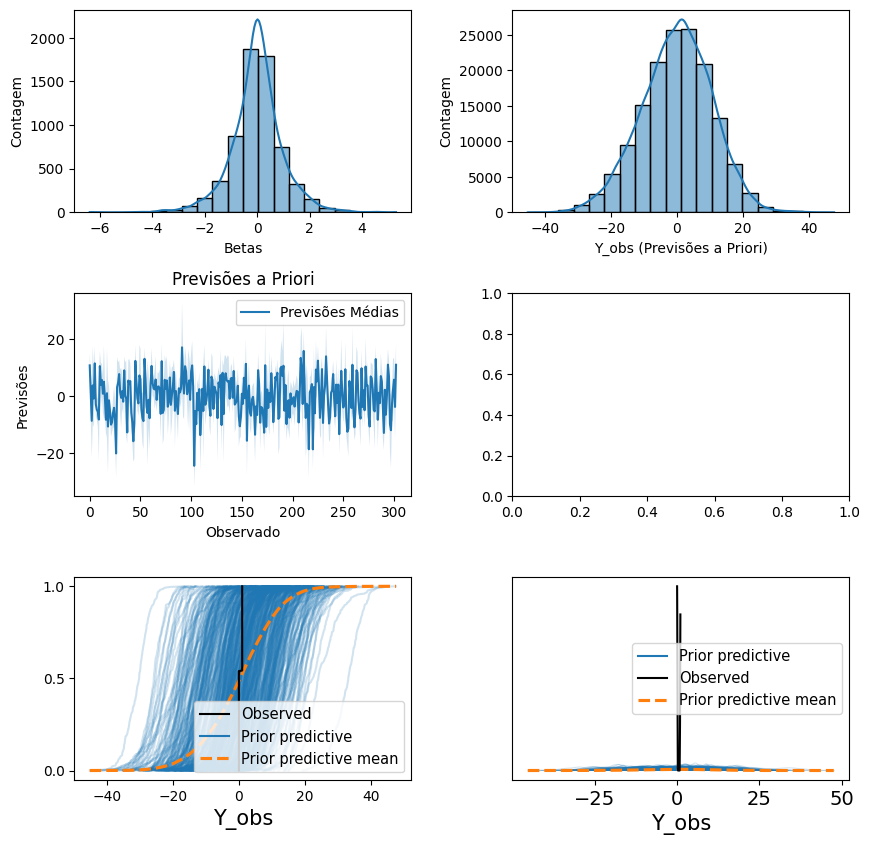

In [33]:
# Supondo que 'y' é seu vetor de dados observados
analise_priori(lasso_trace_prior, y)


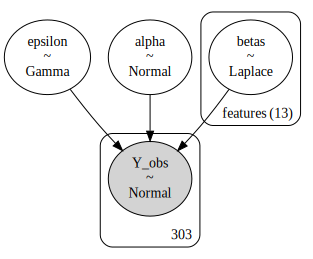

In [41]:

pm.model_to_graphviz(model_lasso)

In [42]:

pm.summary(trace_lasso)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.459,0.020,0.424,0.499,0.000,0.0,3676.0,1615.0,1.0
betas[0],-0.010,0.024,-0.054,0.036,0.000,0.0,3105.0,1676.0,1.0
betas[1],0.068,0.022,0.027,0.111,0.000,0.0,2781.0,1790.0,1.0
betas[2],0.083,0.022,0.041,0.124,0.000,0.0,3171.0,1406.0,1.0
betas[3],0.035,0.021,-0.004,0.076,0.000,0.0,2909.0,1586.0,1.0
betas[4],0.018,0.021,-0.023,0.057,0.000,0.0,2523.0,1452.0,1.0
betas[5],-0.026,0.022,-0.070,0.011,0.000,0.0,3001.0,1357.0,1.0
betas[6],0.032,0.021,-0.007,0.074,0.000,0.0,3006.0,1400.0,1.0
betas[7],-0.055,0.025,-0.105,-0.011,0.000,0.0,3095.0,1676.0,1.0
betas[8],0.070,0.024,0.027,0.116,0.000,0.0,3084.0,1459.0,1.0


Output()

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: xlabel='Y_obs'>, <Axes: xlabel='Y_obs'>], dtype=object))

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


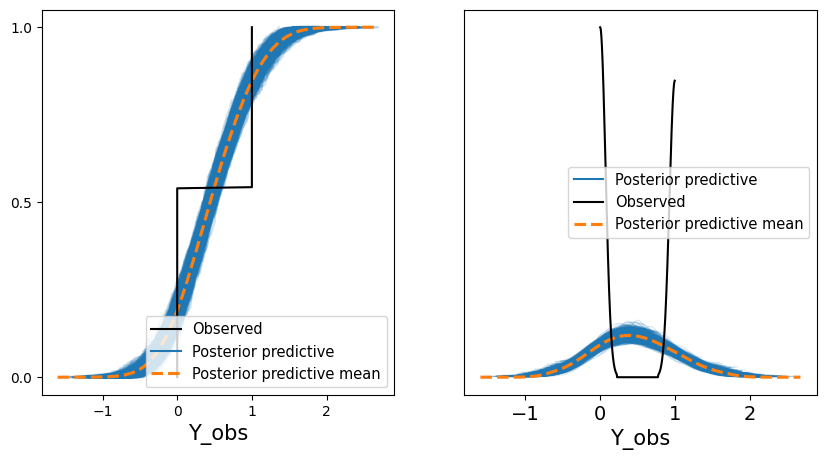

In [36]:
with model_lasso:
  trace_pos_lasso = pm.sample_posterior_predictive(trace_lasso)

analise_posteriori(trace_pos_lasso)

HIERARQUICO

In [43]:


# Definir as coordenadas do modelo
coords = {'features': np.arange(X_scaled.shape[1])}

# Criar o modelo Lasso Bayesiano Hierárquico
with pm.Model(coords=coords) as model_hierarchical:
    # Priori para o intercepto (alpha)
    alpha = pm.Normal('alpha', mu=0, sigma=10)

    # Priori hiperparamétrica para o desvio padrão das Laplaces dos betas
    b_hyper = pm.Gamma('b_hyper', alpha=2, beta=1)

    # Priori hierárquica para os coeficientes de regressão (betas) com priori Laplace
    betas = pm.Laplace('betas', mu=0, b=b_hyper, dims='features')  # b é o parâmetro de escala da Laplace

    # Priori hiperparamétrica para o desvio padrão do erro (epsilon)
    epsilon_hyper = pm.Gamma('epsilon_hyper', alpha=2, beta=1)
    epsilon = pm.HalfNormal('epsilon', sigma=epsilon_hyper)

    # Definir a equação do modelo linear
    mu = alpha + tt.dot(X_scaled, betas)

    # Definir a verossimilhança (Normal)
    likelihood = pm.Normal('Y_obs', mu=mu, sigma=epsilon, observed=y)

    # Amostrar da distribuição a priori
    trace_prior_hierarchical = pm.sample_prior_predictive()

    # Amostrar da distribuição posterior
    trace_hierarchical = pm.sample(1000, tune=1000, target_accept=0.95)

    # Calcular log_likelihood
    pm.compute_log_likelihood(trace_hierarchical)  # Calcular o log_likelihood após a amostragem

Output()

Output()

Output()

In [44]:
print(trace_hierarchical.groups())


['posterior', 'log_likelihood', 'sample_stats', 'observed_data']


<ipython-input-12-720b9792f2ee>:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


(<Figure size 1000x1000 with 6 Axes>,
 array([[<Axes: xlabel='Betas', ylabel='Contagem'>,
         <Axes: xlabel='Y_obs (Previsões a Priori)', ylabel='Contagem'>],
        [<Axes: title={'center': 'Previsões a Priori'}, xlabel='Observado', ylabel='Previsões'>,
         <Axes: >],
        [<Axes: xlabel='Y_obs'>, <Axes: xlabel='Y_obs'>]], dtype=object))

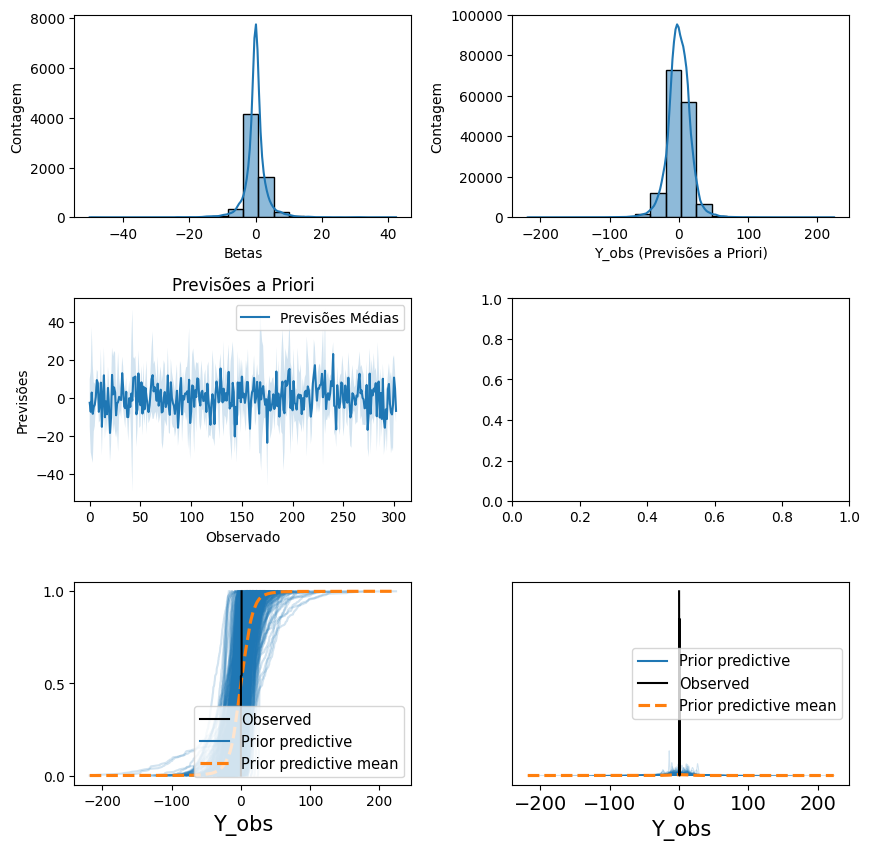

In [45]:

analise_priori(trace_prior_hierarchical,y)

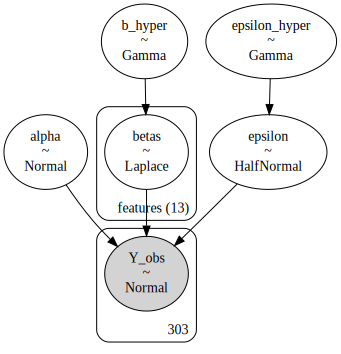

In [46]:

pm.model_to_graphviz(model_hierarchical)

In [47]:

pm.summary(trace_hierarchical)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.459,0.021,0.419,0.498,0.000,0.000,3143.0,1296.0,1.00
b_hyper,0.069,0.023,0.034,0.112,0.000,0.000,3046.0,1176.0,1.00
betas[0],-0.003,0.021,-0.043,0.039,0.000,0.000,2699.0,1588.0,1.00
betas[1],0.063,0.023,0.019,0.105,0.000,0.000,2231.0,1485.0,1.00
betas[2],0.081,0.023,0.036,0.122,0.000,0.000,3405.0,1351.0,1.00
betas[3],0.029,0.021,-0.008,0.068,0.000,0.000,2759.0,1727.0,1.00
betas[4],0.015,0.020,-0.022,0.053,0.000,0.000,3348.0,1448.0,1.00
betas[5],-0.020,0.020,-0.061,0.014,0.000,0.000,2608.0,1050.0,1.01
betas[6],0.029,0.020,-0.009,0.066,0.000,0.000,3427.0,1373.0,1.00
betas[7],-0.050,0.025,-0.097,-0.006,0.001,0.000,2477.0,1412.0,1.00


Output()

<Axes: xlabel='Y_obs'>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


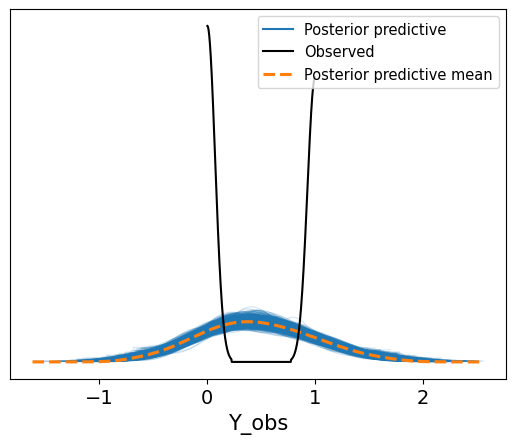

In [49]:
with model_hierarchical:
  trace_pos_hierarc = pm.sample_posterior_predictive(trace_hierarchical)


# Agora, passe o posterior_predictive para a função de análise posterior
az.plot_ppc(posterior_predictive, data_pairs={"Y_obs": "Y_obs"})

ROBUSTO

In [50]:

with pm.Model(coords=coords) as model_robust:
  alpha = pm.Normal('alpha', 0, 1)
  betas = pm.Normal('betas', 0, 1, dims='features')

  df = pm.Exponential('df', 1)
  mu = alpha + tt.dot(X_scaled, betas)

  likelihood = pm.StudentT('Y_obs', nu=df, mu=mu, observed=y)
  robust_trace_prior = pm.sample_prior_predictive()
  trace_robust = pm.sample()


Output()

Output()

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:250: RuntimeWarning: divide by zero encountered in scalar power
  out = t - (2 * N * np.pi**0.5 * f) ** (-0.4)


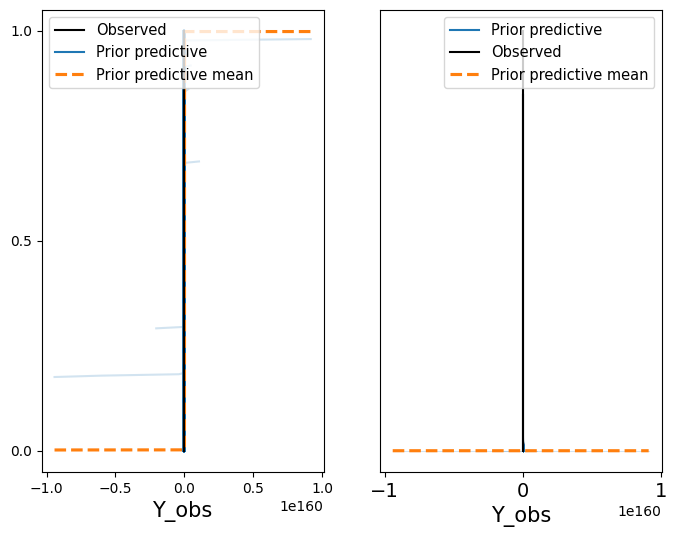

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(8,6))

az.plot_ppc(robust_trace_prior, group='prior', kind='cumulative',ax=axes[0], observed=True);
az.plot_ppc(robust_trace_prior, group='prior',ax=axes[1], observed=True);

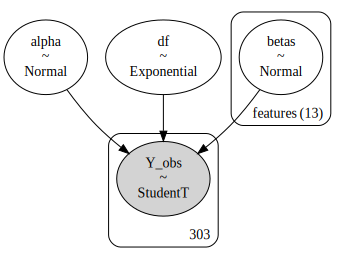

In [52]:

pm.model_to_graphviz(model_robust)

In [53]:

pm.summary(trace_robust)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.457,0.055,0.353,0.561,0.001,0.001,4967.0,1234.0,1.00
betas[0],-0.013,0.069,-0.139,0.120,0.001,0.001,3504.0,1587.0,1.00
betas[1],0.069,0.065,-0.050,0.191,0.001,0.001,3182.0,1489.0,1.00
betas[2],0.084,0.067,-0.043,0.210,0.001,0.001,3422.0,1572.0,1.00
betas[3],0.037,0.061,-0.074,0.149,0.001,0.001,3859.0,1464.0,1.00
betas[4],0.017,0.059,-0.093,0.131,0.001,0.001,3607.0,1602.0,1.01
betas[5],-0.028,0.059,-0.134,0.086,0.001,0.001,3958.0,1483.0,1.01
betas[6],0.031,0.058,-0.080,0.137,0.001,0.001,4135.0,1209.0,1.00
betas[7],-0.055,0.068,-0.189,0.063,0.001,0.001,3219.0,1949.0,1.00
betas[8],0.071,0.066,-0.043,0.203,0.001,0.001,4072.0,1479.0,1.00


Output()

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: xlabel='Y_obs'>, <Axes: xlabel='Y_obs'>], dtype=object))

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


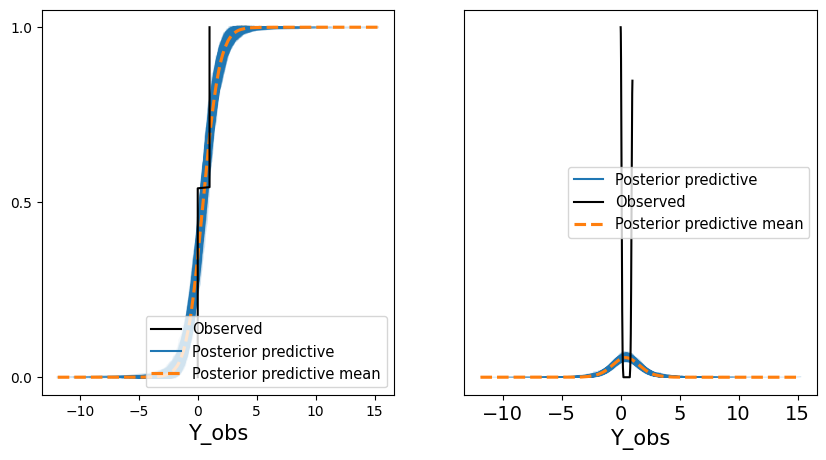

In [54]:


with model_robust:
  trace_pos_robust = pm.sample_posterior_predictive(trace_robust)

analise_posteriori(trace_pos_robust)

COMPARANDO MODELOS

In [55]:

# Função para listar variáveis dentro do InferenceData
def list_trace_variables(trace, model_name):
    print(f"Variáveis no trace do modelo {model_name}:")
    if hasattr(trace, 'posterior'):
        print(list(trace.posterior.keys()))
    else:
        print("Posterior não encontrado no trace.")

# Listar as variáveis nos traços de cada modelo
list_trace_variables(trace_ridge, "Ridge")
list_trace_variables(trace_hierarchical, "Hierarchical")
list_trace_variables(trace_lasso, "Lasso")
list_trace_variables(trace_robust, "Robust")


Variáveis no trace do modelo Ridge:
['alpha', 'betas', 'epsilon']
Variáveis no trace do modelo Hierarchical:
['alpha', 'b_hyper', 'betas', 'epsilon', 'epsilon_hyper']
Variáveis no trace do modelo Lasso:
['alpha', 'betas', 'epsilon']
Variáveis no trace do modelo Robust:
['alpha', 'betas', 'df']


In [61]:
# Recalculando os traços corretamente dentro do contexto de cada modelo
with model_ridge:
    trace_ridge = pm.sample()

with model_hierarchical:
    trace_hierarchical = pm.sample()

with model_lasso:
    trace_lasso = pm.sample()

with model_robust:
    trace_robust = pm.sample()



Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

In [62]:
# Verificar se o log_likelihood já existe antes de recalcular
if 'log_likelihood' not in trace_ridge.groups():
    with model_ridge:
        pm.compute_log_likelihood(trace_ridge)


if 'log_likelihood' not in trace_lasso.groups():
    with model_lasso:
        pm.compute_log_likelihood(trace_lasso)

if 'log_likelihood' not in trace_robust.groups():
    with model_robust:
        pm.compute_log_likelihood(trace_robust)

Output()

Output()

Output()

In [63]:
# Verifique se o log_likelihood foi corretamente adicionado
print(trace_ridge.groups())

print(trace_lasso.groups())

print(trace_robust.groups())

print(trace_hierarchical.groups())


['posterior', 'log_likelihood', 'sample_stats', 'observed_data']
['posterior', 'log_likelihood', 'sample_stats', 'observed_data']
['posterior', 'log_likelihood', 'sample_stats', 'observed_data']
['posterior', 'sample_stats', 'observed_data']


In [67]:
with model_hierarchical:
    trace_hierarchical = pm.sample(draws=500, tune=500, return_inferencedata=True)
    pm.compute_log_likelihood(trace_hierarchical)  # Calcule o log_likelihood imediatamente após




Output()

Output()

Output()

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1647: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1647: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


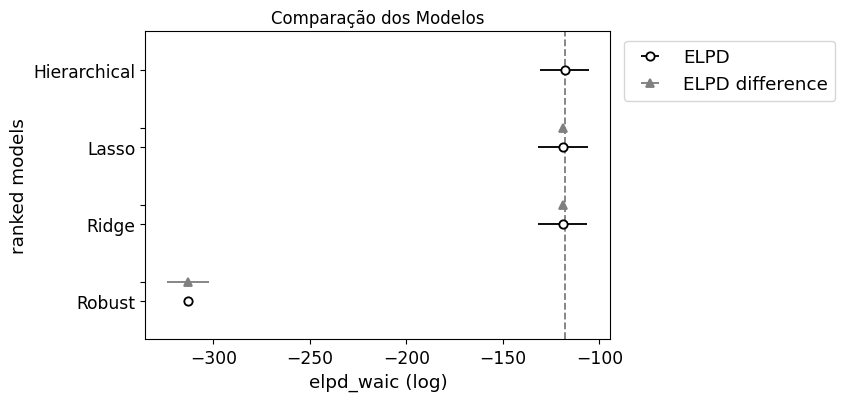

In [68]:


# Comparar os modelos usando o critério WAIC (ou LOO, se preferir)
comparison = az.compare({
    "Ridge": trace_ridge,
    "Lasso": trace_lasso,
    "Hierarchical": trace_hierarchical,
    "Robust": trace_robust
}, ic="waic")  # Você pode usar "loo" no lugar de "waic" se preferir

# Plotar a comparação
az.plot_compare(comparison)
plt.title("Comparação dos Modelos")
plt.show()
